# Project 3 Behavioural Cloning
## Background


## Rationale

## Plan

## Conclusion



### Load Data

In [1]:
import cv2
import csv
import numpy as np

In [23]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

lines = lines[1:]
        
images = []
measurements = []
for line in lines:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = './data/IMG/' + filename
    image = cv2.imread(current_path, 1) # 0 = grayscale, 1 = Colour
    
    # Preprocess with CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     image = clahe.apply(image)
    
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
X_train = np.array(images)
y_train = np.array(measurements)    


In [24]:
## Split into train and validation

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [25]:
from __future__ import print_function
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32
epochs = 1
learn_rate = 0.001

# input image dimensions
img_rows, img_cols = 160, 320
# Colour
input_shape = (img_rows, img_cols, 3)
# Grayscale
#input_shape = (img_rows, img_cols, 1)

x_train shape: (5625, 160, 320, 3)
y_train shape: (5625,)
5625 train samples
2411 validation samples


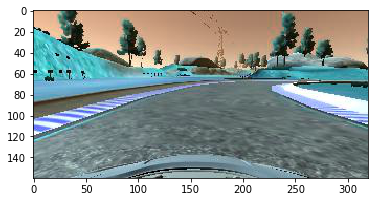

In [26]:
# FIX  RANK <4 issue
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
    
img = X_train[0]
imgplot = plt.imshow(img)

X_train = X_train.astype('float32').reshape((5625, 160, 320, 3))
X_valid = X_valid.astype('float32').reshape((2411, 160, 320, 3))
X_train /= 255
X_valid /= 255
print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')

In [27]:
# Save Processed Data
import pickle
with open('X_train.p','wb') as myfile:
    pickle.dump(X_train, myfile)   

with open('X_valid.p','wb') as myfile:
    pickle.dump(X_valid, myfile)   
    
with open('y_train.p','wb') as myfile:
    pickle.dump(y_train, myfile)  

with open('y_valid.p','wb') as myfile:
    pickle.dump(y_valid, myfile)   


OSError: [Errno 22] Invalid argument

### Image Augmentation

In [29]:
from keras.preprocessing.image import ImageDataGenerator

# Create Data Generator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)




In [31]:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5),
    ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)
]

drop_rate = 0.3

model = Sequential()
# Conv Layer 1
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(160,320,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

# Conv Layer 3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learn_rate))

# Model without Image Augmentation
# model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_valid, y_valid),
#           shuffle=True,
#           callbacks=callbacks)
# model.save('model.h5')

# fits the model on batches with real-time data augmentation:
model.fit_generator(generator=datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=datagen.flow(X_valid, y_valid, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, 
                    validation_steps=len(X_valid) / 32,
                    epochs=epochs,
                    callbacks=callbacks)

# Save model in callbacks
# model.save('model.h5')

Epoch 1/1
176/175 [==============================] - 199s - loss: 3.0810 - val_loss: 0.0152